In [ ]:
# install wandb
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 16.1 MB/s 
     |████████████████████████████████| 182 kB 61.5 MB/s 
     |████████████████████████████████| 168 kB 65.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 54.6 MB/s 
     |████████████████████████████████| 166 kB 65.4 MB/s 
     |████████████████████████████████| 162 kB 75.2 MB/s 
     |████████████████████████████████| 162 kB 69.6 MB/s 
     |████████████████████████████████| 158 kB 70.5 MB/s 
     |████████████████████████████████| 157 kB 78.2 MB/s 
     |████████████████████████████████| 157 kB 77.5 MB/s 
     |████████████████████████████████| 157 kB 70.0 MB/s 
     |████████████████████████████████| 157 kB 73.6 MB/s 
     |████████████████████████████████| 157 kB 76.1 MB/s 
     |████████████████████████████████| 157 kB 72.9 MB/s 
     |████████████████████████████████| 157 kB 72.5 MB/s 
     |████████████████████████████████| 156 kB 69.4 MB/s 


In [ ]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 8.8 MB/s 
     |████████████████████████████████| 46 kB 5.1 MB/s 
     |████████████████████████████████| 66 kB 4.8 MB/s 


In [ ]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
from codecarbon import EmissionsTracker

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "transfer_learning_VGG-16",
  "artifact_name": "animals_raw_data:latest",
  "artifact_name_feature": "clean_data:latest",
  "artifact_name_target": "label:latest"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="gildson",project=args["project_name"], job_type="transfer_learnimg")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

logger.info("Downloading and reading clean data artifact")
clean_data = run.use_artifact(args["artifact_name_feature"])
clean_data_path = clean_data.file()

logger.info("Downloading and reading label data artifact")
label_data = run.use_artifact(args["artifact_name_target"])
label_data_path = label_data.file()

# unpacking the artifacts
data = joblib.load(clean_data_path)
label = joblib.load(label_data_path)

wandb: Currently logged in as: gildson. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact animals_raw_data:latest, 94.21MB. 950 files... 
wandb:   950 of 950 files downloaded.  
Done. 0:0:19.5
20-11-2022 14:49:52 Path: ./artifacts/animals_raw_data:v0
20-11-2022 14:49:52 Downloading and reading clean data artifact
20-11-2022 14:49:54 Downloading and reading label data artifact


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 950 files belonging to 2 classes.


In [ ]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [ ]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 30
Number of train batches: 24
Number of validation batches: 5
Number of test batches: 1


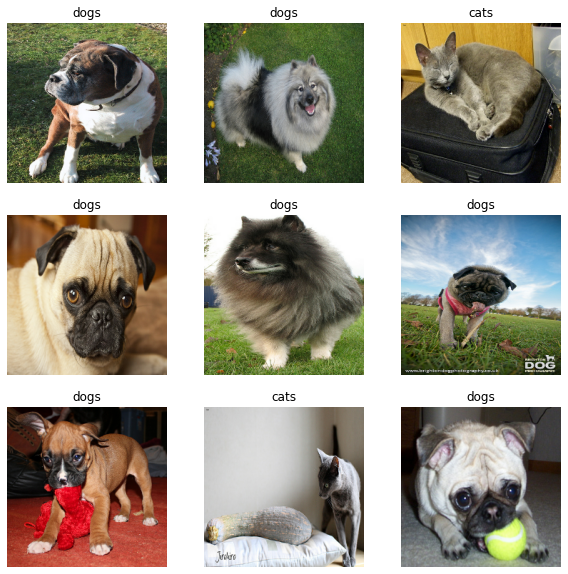

In [ ]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

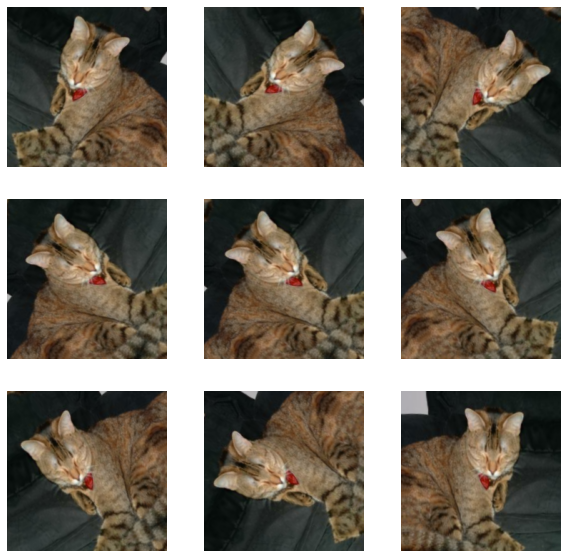

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Transfer learning with feature extractor

In [ ]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [ ]:
model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
n_classes=2
prediction_layer = tf.keras.layers.Dense(n_classes,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                         compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
20-11-2022 14:51:29 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5254: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 5.0659 - accuracy: 0.3958

20-11-2022 14:51:44 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:51:45 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 16s 531ms/step - loss: 5.0659 - accuracy: 0.3958 - val_loss: 4.3482 - val_accuracy: 0.4875
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 4.2349 - accuracy: 0.4499

20-11-2022 14:51:56 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:51:56 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 427ms/step - loss: 4.2349 - accuracy: 0.4499 - val_loss: 3.4851 - val_accuracy: 0.4812
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 3.2193 - accuracy: 0.5330

20-11-2022 14:52:16 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:52:16 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 414ms/step - loss: 3.2193 - accuracy: 0.5330 - val_loss: 2.6191 - val_accuracy: 0.6062
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 2.8138 - accuracy: 0.5554

20-11-2022 14:52:27 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:52:28 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 432ms/step - loss: 2.8138 - accuracy: 0.5554 - val_loss: 2.3798 - val_accuracy: 0.6438
Epoch 5/20
24/24 [==============================] - ETA: 0s - loss: 2.8466 - accuracy: 0.5580

20-11-2022 14:52:47 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:52:48 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 422ms/step - loss: 2.8466 - accuracy: 0.5580 - val_loss: 1.7348 - val_accuracy: 0.6687
Epoch 6/20
24/24 [==============================] - ETA: 0s - loss: 2.5299 - accuracy: 0.5910

20-11-2022 14:53:08 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:53:08 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 431ms/step - loss: 2.5299 - accuracy: 0.5910 - val_loss: 1.4112 - val_accuracy: 0.7563
Epoch 7/20
24/24 [==============================] - ETA: 0s - loss: 2.0662 - accuracy: 0.6372

20-11-2022 14:53:19 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:53:19 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 419ms/step - loss: 2.0662 - accuracy: 0.6372 - val_loss: 1.3542 - val_accuracy: 0.7188
Epoch 8/20
24/24 [==============================] - ETA: 0s - loss: 1.8773 - accuracy: 0.6728

20-11-2022 14:53:30 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:53:31 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 437ms/step - loss: 1.8773 - accuracy: 0.6728 - val_loss: 1.0904 - val_accuracy: 0.7750
Epoch 9/20
24/24 [==============================] - ETA: 0s - loss: 1.7140 - accuracy: 0.6887

20-11-2022 14:53:41 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:53:42 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 423ms/step - loss: 1.7140 - accuracy: 0.6887 - val_loss: 0.7034 - val_accuracy: 0.8125
Epoch 10/20
24/24 [==============================] - 7s 242ms/step - loss: 1.3768 - accuracy: 0.7375 - val_loss: 0.8949 - val_accuracy: 0.8125
Epoch 11/20
24/24 [==============================] - ETA: 0s - loss: 1.3985 - accuracy: 0.7375

20-11-2022 14:54:12 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:54:13 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 432ms/step - loss: 1.3985 - accuracy: 0.7375 - val_loss: 0.4238 - val_accuracy: 0.8687
Epoch 12/20
24/24 [==============================] - 7s 241ms/step - loss: 1.3033 - accuracy: 0.7533 - val_loss: 0.6080 - val_accuracy: 0.8438
Epoch 13/20
24/24 [==============================] - ETA: 0s - loss: 1.1887 - accuracy: 0.7586

20-11-2022 14:54:39 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:54:39 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 418ms/step - loss: 1.1887 - accuracy: 0.7586 - val_loss: 0.3751 - val_accuracy: 0.9125
Epoch 14/20
24/24 [==============================] - ETA: 0s - loss: 1.3108 - accuracy: 0.7665

20-11-2022 14:54:59 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:55:00 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 431ms/step - loss: 1.3108 - accuracy: 0.7665 - val_loss: 0.3691 - val_accuracy: 0.9125
Epoch 15/20
24/24 [==============================] - 7s 249ms/step - loss: 0.9953 - accuracy: 0.7942 - val_loss: 0.4704 - val_accuracy: 0.9062
Epoch 16/20
24/24 [==============================] - ETA: 0s - loss: 0.8953 - accuracy: 0.8140

20-11-2022 14:55:21 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:55:21 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 416ms/step - loss: 0.8953 - accuracy: 0.8140 - val_loss: 0.3040 - val_accuracy: 0.9125
Epoch 17/20
24/24 [==============================] - ETA: 0s - loss: 0.8873 - accuracy: 0.8259

20-11-2022 14:55:32 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:55:32 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 433ms/step - loss: 0.8873 - accuracy: 0.8259 - val_loss: 0.2387 - val_accuracy: 0.9250
Epoch 18/20
24/24 [==============================] - ETA: 0s - loss: 0.8872 - accuracy: 0.8272

20-11-2022 14:55:52 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:55:52 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.4s


24/24 [==============================] - 11s 412ms/step - loss: 0.8872 - accuracy: 0.8272 - val_loss: 0.2222 - val_accuracy: 0.9312
Epoch 19/20
24/24 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.8417

20-11-2022 14:56:03 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:56:04 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 435ms/step - loss: 0.7481 - accuracy: 0.8417 - val_loss: 0.2130 - val_accuracy: 0.9375
Epoch 20/20
24/24 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.8562

20-11-2022 14:56:23 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 14:56:24 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 420ms/step - loss: 0.6981 - accuracy: 0.8562 - val_loss: 0.1632 - val_accuracy: 0.9375


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

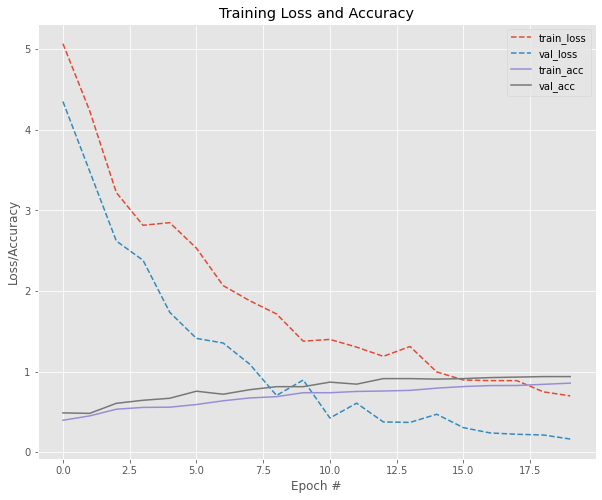

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy of the transfer learning with feature extractor": wandb.Image(fig),
    }
)

20-11-2022 14:56:45 Uploading figures


In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.007655657198011538 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00039211013886398453 kWh
[INFO] Energy consumed for all GPU: 0.003756856676852372 kWh
[INFO] Energy consumed for all CPU: 0.0035066903822951853 kWh
[INFO] CO2 emission 0.0024344989889676693(in Kg)


In [ ]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y2 = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
1/1 [==============================] - 0s 183ms/step
              precision    recall  f1-score   support

        cats       1.00      0.82      0.90        11
        dogs       0.91      1.00      0.95        21

    accuracy                           0.94        32
   macro avg       0.96      0.91      0.93        32
weighted avg       0.94      0.94      0.94        32



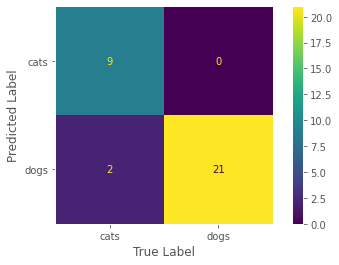

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix of the transfer learning with feature extractor": wandb.Image(fig_confusion_matrix),
    }
)

20-11-2022 14:57:20 Uploading figures


In [ ]:
# number of parameters
run.summary["Count_Params transfer learning with feature extractor"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed transfer learning with feature extractor"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM transfer learning with feature extractor"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU transfer learning with feature extractor"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU transfer learning with feature extractor"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions transfer learning with feature extractor"] = tracker.final_emissions_data.emissions

Transfer learning with fine-tuning

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG16

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [ ]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [ ]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [ ]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-t

In [ ]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [ ]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[4].layers:
	layer.trainable = False


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] training head...
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 3.3199 - accuracy: 0.8615

20-11-2022 15:08:51 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 15:08:52 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.9s


24/24 [==============================] - 13s 473ms/step - loss: 3.3199 - accuracy: 0.8615 - val_loss: 7.1995e-05 - val_accuracy: 1.0000
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 0.5757 - accuracy: 0.9525

20-11-2022 15:09:03 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 15:09:04 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.8s


24/24 [==============================] - 12s 464ms/step - loss: 0.5757 - accuracy: 0.9525 - val_loss: 2.5332e-07 - val_accuracy: 1.0000
Epoch 3/20
24/24 [==============================] - 7s 249ms/step - loss: 0.4587 - accuracy: 0.9617 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.9749

20-11-2022 15:09:25 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 15:09:25 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.9s


24/24 [==============================] - 12s 451ms/step - loss: 0.2772 - accuracy: 0.9749 - val_loss: 4.8429e-08 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 7s 268ms/step - loss: 0.1842 - accuracy: 0.9881 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
24/24 [==============================] - 7s 243ms/step - loss: 0.2877 - accuracy: 0.9749 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
24/24 [==============================] - 7s 245ms/step - loss: 0.0897 - accuracy: 0.9921 - val_loss: 3.6340e-04 - val_accuracy: 1.0000
Epoch 8/20
24/24 [==============================] - 7s 245ms/step - loss: 0.2083 - accuracy: 0.9815 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9/20
24/24 [==============================] - 7s 246ms/step - loss: 0.1454 - accuracy: 0.9855 - val_loss: 4.6758e-06 - val_accuracy: 1.0000
Epoch 10/20
24/24 [==============================] - 7s 244ms/step - loss: 0.0979 - accuracy: 0.9894 - val_loss: 5.7369e-08 - val_accu

20-11-2022 15:11:07 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 15:11:08 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.9s


24/24 [==============================] - 12s 463ms/step - loss: 0.0898 - accuracy: 0.9934 - val_loss: 2.7567e-08 - val_accuracy: 1.0000
Epoch 15/20
24/24 [==============================] - 7s 247ms/step - loss: 0.0505 - accuracy: 0.9960 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 16/20
24/24 [==============================] - 7s 250ms/step - loss: 0.1903 - accuracy: 0.9776 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 17/20
24/24 [==============================] - 7s 251ms/step - loss: 0.0718 - accuracy: 0.9908 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 18/20
24/24 [==============================] - 7s 249ms/step - loss: 0.1104 - accuracy: 0.9921 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 19/20
24/24 [==============================] - 7s 246ms/step - loss: 0.0361 - accuracy: 0.9960 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 20/20
24/24 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9974

20-11-2022 15:12:15 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
20-11-2022 15:12:16 Assets written to: /content/wandb/run-20221120_144925-1rzbr66i/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221120_144925-1rzbr66i/files/model-best)... Done. 0.9s


24/24 [==============================] - 12s 448ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 7.4506e-10 - val_accuracy: 1.0000


In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[4].layers[15:]:
	layer.trainable = True

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] re-compiling model...
[INFO] training head...
Epoch 1/20
24/24 [==============================] - 10s 277ms/step - loss: 0.0193 - accuracy: 0.9974 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
24/24 [==============================] - 7s 264ms/step - loss: 0.0557 - accuracy: 0.9974 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
24/24 [==============================] - 7s 267ms/step - loss: 0.0254 - accuracy: 0.9947 - val_loss: 7.4506e-10 - val_accuracy: 1.0000
Epoch 4/20
24/24 [==============================] - 7s 269ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 7s 267ms/step - loss: 0.0121 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
24/24 [==============================] - 7s 264ms/step - loss: 0.0210 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
24/24 [==============================] - 7s 263ms/step - lo

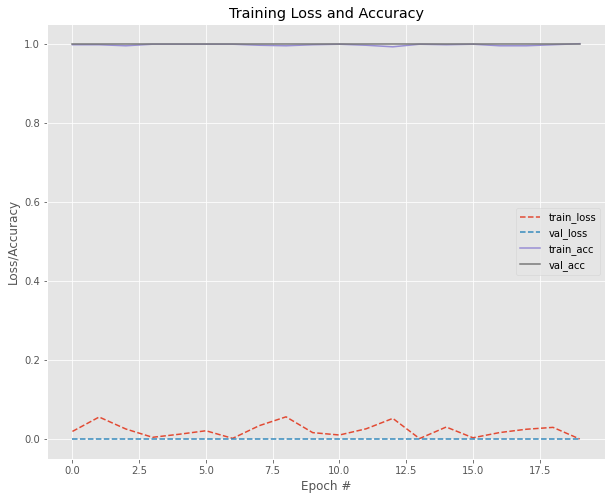

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy transfer learning with fine tuning": wandb.Image(fig),
    }
)

20-11-2022 15:16:53 Uploading figures


In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.005717677925492123 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00024658233778350366 kWh
[INFO] Energy consumed for all GPU: 0.0032656141780132053 kWh
[INFO] Energy consumed for all CPU: 0.002205481409695414 kWh
[INFO] CO2 emission 0.0018182215803064952(in Kg)


In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
1/1 [==============================] - 0s 143ms/step
              precision    recall  f1-score   support

        cats       1.00      1.00      1.00         9
        dogs       1.00      1.00      1.00        23

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



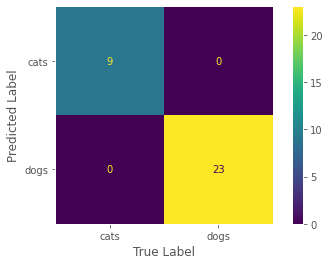

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix transfer learning with fine tuning": wandb.Image(fig_confusion_matrix),
    }
)

20-11-2022 15:17:11 Uploading figures


In [ ]:
# number of parameters
run.summary["Count_Params transfer learning with fine tuning"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed transfer learning with fine tuning"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM transfer learning with fine tuning"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU transfer learning with fine tuning"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU transfer learning with fine tuning"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions transfer learning with fine tuning"] = tracker.final_emissions_data.emissions

In [ ]:
run.finish()

accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▇█████████████████████████
epoch,▁▁▂▂▃▄▄▅▅▆▇▇██▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▄▅▅▆▇▇█
loss,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▄▄▅▅▆▇▇▇▇▇▇██████████████████████████
val_loss,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CO2_Emissions transfer learning with feature extractor,0.00243
CO2_Emissions transfer learning with fine tuning,0.00182
Count_Params transfer learning with feature extractor,14715714
Count_Params transfer learning with fine tuning,21137986
Energy_CPU transfer learning with feature extractor,0.00351
Energy_CPU transfer learning with fine tuning,0.00221
